# Imports

In [13]:
from transformers import BertTokenizerFast, BertForTokenClassification, get_scheduler, Trainer, TrainingArguments, AdamW
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from datasets import load_dataset
from datasets import Dataset



# Tokenização com BERT

In [14]:
# Configurações iniciais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caminhos para os arquivos de dados
train_file = "./corpus/macmorpho-train.txt"
val_file = "./corpus/macmorpho-dev.txt"
test_file = "./corpus/macmorpho-test.txt"

data_files = {
    "train": train_file,
    "validation": val_file,
    "test": test_file,
}

In [15]:
# Função para carregar os dados
def load_data(filepath):
    sentences = []
    labels = []
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            tokens, tags = [], []
            for pair in line.strip().split():
                word, tag = pair.rsplit("_", 1)
                tokens.append(word)
                tags.append(tag)
            sentences.append(tokens)
            labels.append(tags)
    return sentences, labels

In [16]:
# Carregar os dados
tokens_train, tags_train = load_data(train_file)
tokens_val, tags_val = load_data(val_file)
tokens_test, tags_test = load_data(test_file)

In [17]:
# Inicializar o tokenizer e o modelo pré-treinado
tokenizer = BertTokenizerFast.from_pretrained("neuralmind/bert-base-portuguese-cased")
num_classes = len(set(tag for sent_tags in tags_train for tag in sent_tags))

model = BertForTokenClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=num_classes
).to(device)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Label Encoder para as tags
tag_encoder = LabelEncoder()
tag_encoder.fit([tag for sent_tags in tags_train for tag in sent_tags])

def preprocess(sentences, tags, tokenizer, tag_encoder):
    input_ids, attention_masks, labels = [], [], []

    for sentence, tag_seq in zip(sentences, tags):
        # Tokenizar as frases
        encoding = tokenizer(
            sentence,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        # Ajustar os rótulos para sub-tokens
        word_ids = encoding.word_ids()
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignorar sub-tokens fora da sequência
            elif word_idx != previous_word_idx:
                label_ids.append(tag_encoder.transform([tag_seq[word_idx]])[0])
            else:
                label_ids.append(-100)  # Ignorar sub-tokens adicionais

            previous_word_idx = word_idx

        input_ids.append(encoding["input_ids"])
        attention_masks.append(encoding["attention_mask"])
        labels.append(torch.tensor(label_ids))

    return torch.cat(input_ids), torch.cat(attention_masks), torch.stack(labels)


In [19]:
# Pré-processar os dados
train_inputs, train_masks, train_labels = preprocess(tokens_train, tags_train, tokenizer, tag_encoder)
val_inputs, val_masks, val_labels = preprocess(tokens_val, tags_val, tokenizer, tag_encoder)

def create_dataloader(inputs, masks, labels, batch_size=16):
    data = TensorDataset(inputs, masks, labels)
    return DataLoader(data, batch_size=batch_size)


In [20]:
# Criar os DataLoaders
train_dataloader = create_dataloader(train_inputs, train_masks, train_labels) #usar para treinar
test_dataloader = create_dataloader(val_inputs, val_masks, val_labels) #usar para testar
val_dataloader = create_dataloader(val_inputs, val_masks, val_labels) #usar para validar


In [21]:
def compute_metrics(eval_pred, tag_encoder):
    logits, labels = eval_pred
    predictions = torch.argmax(logits, dim=-1).flatten().cpu().numpy()
    labels = labels.flatten().cpu().numpy()

    # Ignorar sub-tokens, onde a label é -100
    mask = labels != -100
    predictions = predictions[mask]
    labels = labels[mask]

    accuracy = accuracy_score(labels, predictions)

    #print a palavra o predict e o label
    for i in range(len(labels)):
        print(f'{tag_encoder.inverse_transform([predictions[i]])} - {tag_encoder.inverse_transform([labels[i]])}')
    # Adicionar outras métricas, se necessário
    return {"accuracy": accuracy}

In [22]:
PATH = "./training_output"
# Definir o otimizador
optimizer = AdamW(model.parameters(), lr=5e-5)
unique_labels = tag_encoder.classes_

# Supondo que os arquivos estejam no formato linha por linha (ajuste o formato, se necessário)
datasets = load_dataset("text", data_files=data_files)

# Divisão dos datasets
train_dataset = datasets["train"]
test_dataset = datasets["test"]
val_dataset = datasets["validation"]

# Verificação das amostras (opcional)
print(f"Exemplo de treinamento: {train_dataset[0]}")
print(f"Exemplo de teste: {test_dataset[0]}")
print(f"Exemplo de validação: {val_dataset[0]}")

Exemplo de treinamento: {'text': 'Jersei_N atinge_V média_N de_PREP Cr$_CUR 1,4_NUM milhão_N na_PREP+ART venda_N da_PREP+ART Pinhal_NPROP em_PREP São_NPROP Paulo_NPROP ._PU'}
Exemplo de teste: {'text': 'Salto_N sete_ADJ'}
Exemplo de validação: {'text': 'Ainda_ADV em_PREP dezembro_N de_PREP 1990_N ,_PU foi_V editada_PCP a_ART famosa_ADJ 289_N ,_PU que_PRO-KS modificava_V a_ART sistemática_N da_PREP+ART arrecadação_N do_PREP+ART ITR_NPROP e_KC alterava_V suas_PROADJ alíquotas_N ._PU'}


In [23]:
def create_hf_dataset(inputs, masks, labels):
    data = {
        "input_ids": inputs.tolist(),
        "attention_mask": masks.tolist(),
        "labels": labels.tolist(),
    }
    return Dataset.from_dict(data)

In [24]:
# Criar datasets no formato esperado
train_dataset = create_hf_dataset(train_inputs, train_masks, train_labels)
train_dataset = train_dataset.select(range(500))  # Usar apenas 10.000 exemplos

test_dataset = create_hf_dataset(val_inputs, val_masks, val_labels)
val_dataset = create_hf_dataset(val_inputs, val_masks, val_labels)


training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir=PATH,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=300,
    save_steps=300,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_dir=f"{PATH}/log",
    save_total_limit=2,
    logging_steps=10,
    fp16=True,
)

# Limpar cache da GPU
torch.cuda.empty_cache()

# Criar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # Dataset de treinamento no formato esperado
    eval_dataset=test_dataset,     # Dataset de test no formato esperado
    optimizers=(optimizer, None),  # Passando o otimizador
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, unique_labels),
)

# Iniciar o treinamento
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=8, training_loss=2.8004918098449707, metrics={'train_runtime': 58.6253, 'train_samples_per_second': 8.529, 'train_steps_per_second': 0.136, 'total_flos': 32669181696000.0, 'train_loss': 2.8004918098449707, 'epoch': 1.0})

In [25]:
# Função para salvar o modelo
def save_model(model, tokenizer, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    model.save_pretrained(save_directory)
    tokenizer.save_pretrained(save_directory)
    print(f"Modelo salvo em: {save_directory}")

# %%
# Salvar o modelo após o treinamento
save_directory = "./saved_model"
save_model(model, tokenizer, save_directory)

Modelo salvo em: ./saved_model


In [26]:
# Função para prever as tags ajustadas para cada sentença
def predict_and_adjust_tags(sentences, tokenizer, model, tag_encoder, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    predictions = []
    with torch.no_grad():
        for sentence in sentences:
            # Tokenize the sentence
            encoding = tokenizer(
                sentence,
                is_split_into_words=True,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=128
            ).to(device)
            
            # Get word_ids to adjust the labels
            word_ids = encoding.word_ids()
            output = model(**encoding)
            logits = output.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy().flatten()
            
            # Adjust predictions to map back to words, ignoring sub-tokens
            adjusted_preds = []
            previous_word_idx = None
            for word_idx in word_ids:
                if word_idx is None or word_idx == previous_word_idx:
                    adjusted_preds.append(-100)  # Ignorar sub-tokens
                else:
                    adjusted_preds.append(preds[word_idx])
                previous_word_idx = word_idx
            
            # Decode the predicted tags
            pred_tags = tag_encoder.inverse_transform(adjusted_preds)
            predictions.append(pred_tags)
            
    return predictions

In [27]:
# Avaliação no conjunto de teste
model.eval()
all_predictions = []
all_labels = []

# Para imprimir valores previstos e esperados
print("Valores previstos e esperados (apenas para os primeiros exemplos):")

# Contador para limitar o número de exemplos impressos
print_count = 0
max_print = 10  # Defina o número de exemplos que você deseja imprimir

with torch.no_grad():
    for batch in val_dataloader:  # Você pode trocar por test_dataloader, se necessário
        batch_input_ids, batch_masks, batch_labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_masks)
        logits = outputs.logits
        
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch_labels.cpu().numpy()

        # Ignorar tokens -100
        for pred, label, input_ids in zip(predictions, labels, batch_input_ids):
            mask = label != -100
            pred = pred[mask]
            label = label[mask]
            input_ids = input_ids[mask].cpu().numpy()  # Selecionando apenas os ids de tokens relevantes

            all_predictions.extend(pred)
            all_labels.extend(label)

            if print_count < max_print:
                sentence = tokenizer.decode(input_ids, skip_special_tokens=True)
                predicted_tags = tag_encoder.inverse_transform(pred)
                true_tags = tag_encoder.inverse_transform(label)
                print(f"Sentence: {sentence}")
                print(f"Predicted Tags: {predicted_tags}")
                print(f"True Tags: {true_tags}")
                print("---")
                print_count += 1

# Calcular métricas (por exemplo, acurácia)
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

Valores previstos e esperados (apenas para os primeiros exemplos):
Sentence: Ainda em dezembro de 1990, foi editada a famosa 28, que mod a sistemática da arrecadação do I e alter suas al.
Predicted Tags: ['N' 'PU' 'N' 'PU' 'N' 'PU' 'PU' 'N' 'PU' 'KC' 'PU' 'PU' 'PU' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'PU' 'N' 'N' 'N' 'PU']
True Tags: ['ADV' 'PREP' 'N' 'PREP' 'N' 'PU' 'V' 'PCP' 'ART' 'ADJ' 'N' 'PU' 'PRO-KS'
 'V' 'ART' 'N' 'PREP+ART' 'N' 'PREP+ART' 'NPROP' 'KC' 'V' 'PROADJ' 'N'
 'PU']
---
Sentence: Porém, como a previsão indica entrada de frente fria, deve - aguarda até quarta e irrig somente se o total de chuva for inferior a 30 mm.
Predicted Tags: ['PU' 'PU' 'N' 'PU' 'N' 'N' 'N' 'N' 'N' 'N' 'PU' 'N' 'PU' 'N' 'PU' 'N'
 'PU' 'N' 'N' 'N' 'PU' 'N' 'PU' 'N' 'N' 'N' 'PU' 'N' 'N' 'PU']
True Tags: ['KC' 'PU' 'KS' 'ART' 'N' 'V' 'N' 'PREP' 'N' 'ADJ' 'PU' 'V' 'PROPESS' 'V'
 'PREP' 'N' 'KC' 'V' 'PDEN' 'KS' 'ART' 'N' 'PREP' 'N' 'V' 'ADJ' 'PREP'
 'NUM' 'N' 'PU']
---
Sentence: " O crescimento é express mas,

Sentence: Ainda em dezembro de 1990, foi editada a famosa 28, que mod a sistemática da arrecadação do I e alter suas al.
Word: Ainda      || Predicted Tags: N          || True Tags: ADV       
Word: em         || Predicted Tags: PU         || True Tags: PREP      
Word: dezembro   || Predicted Tags: N          || True Tags: N         
Word: de         || Predicted Tags: PU         || True Tags: PREP      
Word: 1990,      || Predicted Tags: N          || True Tags: N         
Word: foi        || Predicted Tags: PU         || True Tags: PU        
Word: editada    || Predicted Tags: PU         || True Tags: V         
Word: a          || Predicted Tags: N          || True Tags: PCP       
Word: famosa     || Predicted Tags: PU         || True Tags: ART       
Word: 28,        || Predicted Tags: KC         || True Tags: ADJ       
Word: que        || Predicted Tags: PU         || True Tags: N         
Word: mod        || Predicted Tags: PU         || True Tags: PU        
Word: a        

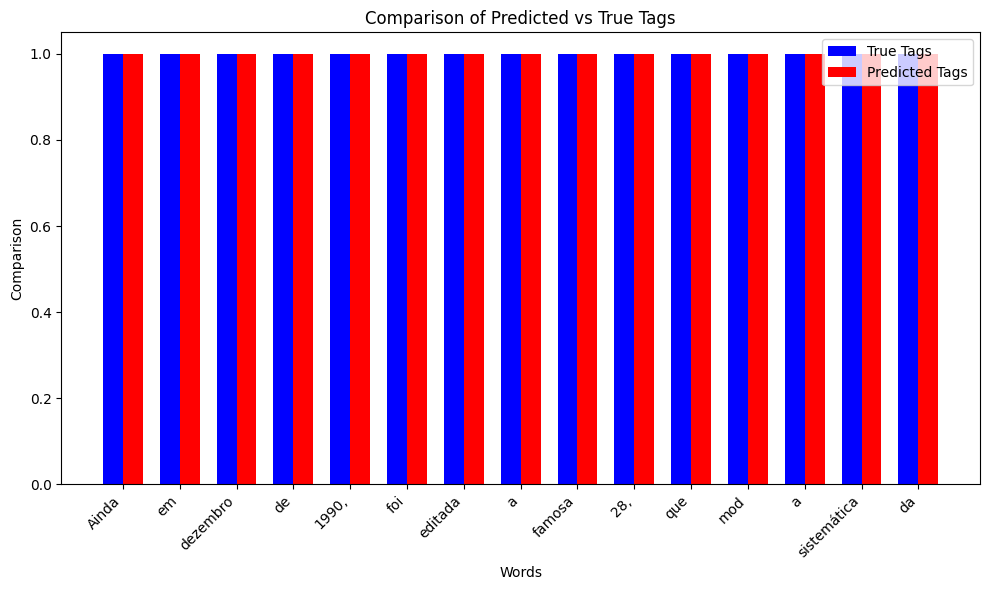

In [ ]:
# Avaliação no conjunto de teste
model.eval()
all_predictions = []
all_labels = []

# Contador para limitar o número de exemplos impressos
print_count = 0
max_print = 10  # Defina o número de exemplos que você deseja imprimir

with torch.no_grad():
    for batch in val_dataloader:  # Você pode trocar por test_dataloader, se necessário
        batch_input_ids, batch_masks, batch_labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_masks)
        logits = outputs.logits
        
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch_labels.cpu().numpy()

        # Ignorar tokens -100
        for pred, label, input_ids in zip(predictions, labels, batch_input_ids):
            mask = label != -100
            pred = pred[mask]
            label = label[mask]
            input_ids = input_ids[mask].cpu().numpy()  # Selecionando apenas os ids de tokens relevantes

            all_predictions.extend(pred)
            all_labels.extend(label)

            if print_count < max_print:
                # Decodificar os ids para obter as palavras
                words = tokenizer.decode(input_ids, skip_special_tokens=True).split()

                # Transformar as previsões e rótulos para as tags
                predicted_tags = tag_encoder.inverse_transform(pred)
                true_tags = tag_encoder.inverse_transform(label)

                print(f"Sentence: {sentence}")
                for word, p, t in zip(words, predicted_tags, true_tags):
                    print(f"Word: {word.ljust(10)} || Predicted Tags: {p.ljust(10)} || True Tags: {t.ljust(10)}")
                print("---")  # Separar cada exemplo

                print_count += 1

# Calcular métricas (por exemplo, acurácia)
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.3457


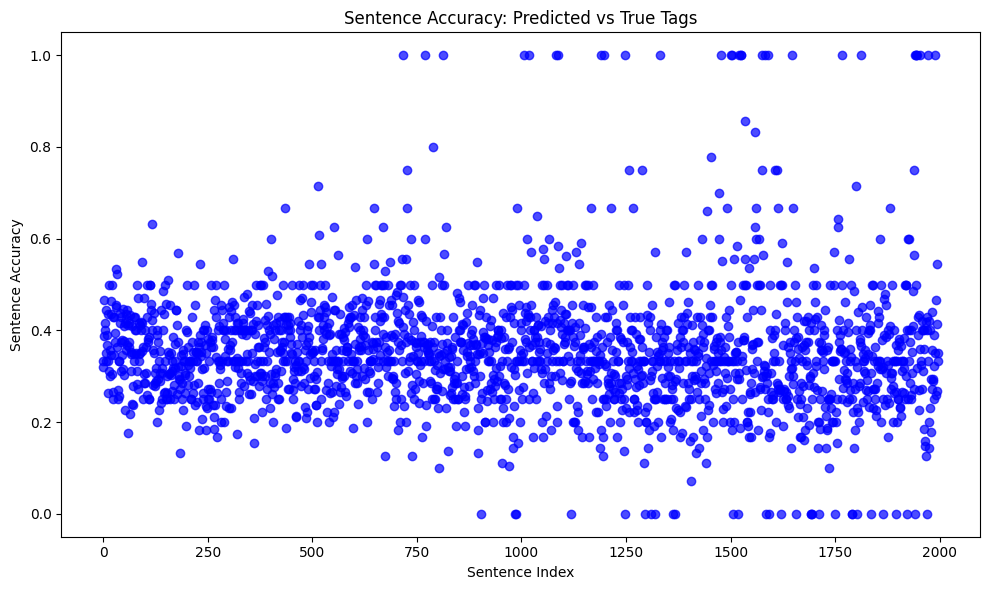

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Avaliação no conjunto de teste
model.eval()
all_predictions = []
all_labels = []

# Listas para armazenar as métricas de cada sentença
sentence_accuracy = []  # Similaridade ou acurácia para cada sentença

with torch.no_grad():
    for batch in val_dataloader:  # Você pode trocar por test_dataloader, se necessário
        batch_input_ids, batch_masks, batch_labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_masks)
        logits = outputs.logits
        
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch_labels.cpu().numpy()

        # Ignorar tokens -100
        for pred, label, input_ids in zip(predictions, labels, batch_input_ids):
            mask = label != -100
            pred = pred[mask]
            label = label[mask]
            input_ids = input_ids[mask].cpu().numpy()  # Selecionando apenas os ids de tokens relevantes

            all_predictions.extend(pred)
            all_labels.extend(label)

            # Decodificar os ids para obter as palavras
            words = tokenizer.decode(input_ids, skip_special_tokens=True).split()

            # Transformar as previsões e rótulos para as tags
            predicted_tags = tag_encoder.inverse_transform(pred)
            true_tags = tag_encoder.inverse_transform(label)

            # Calcular a acurácia para a sentença (por exemplo, tags corretas/total de tags)
            correct_tags = sum([1 if p == t else 0 for p, t in zip(predicted_tags, true_tags)])
            sentence_accuracy.append(correct_tags / len(predicted_tags))  # Acurácia por sentença

# Calcular métricas (por exemplo, acurácia geral)
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Criar um gráfico de dispersão (scatter plot)
fig, ax = plt.subplots(figsize=(10, 6))

# Índices para as sentenças
indices = np.arange(len(sentence_accuracy))

# Plotar bolinhas para cada sentença
ax.scatter(indices, sentence_accuracy, color='b', alpha=0.7)

# Personalização do gráfico
ax.set_xlabel('Sentence Index')
ax.set_ylabel('Sentence Accuracy')
ax.set_title('Sentence Accuracy: Predicted vs True Tags')

# Exibir o gráfico
plt.tight_layout()
plt.show()
